In [32]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.font_manager
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import datedelta

In [33]:
df = pd.read_csv("data/3year_report.csv")

In [58]:
report_date_list = []
project_date_list = []
fund_list = []


for index, value in df.iterrows():
    
    report_date = pd.to_datetime(value['Report Year'], format='%b %Y Report')
    
    for i in range(1, len(value)):
        project_date = pd.to_datetime(value.index[i], format='%b-%y')
        val = float(value[i])

        report_date_list.append(report_date)
        project_date_list.append(project_date)
        fund_list.append(val)

In [59]:
df_new = pd.DataFrame(list(zip(report_date_list, project_date_list, fund_list)), columns =['report_date', 'project_date', 'fund']).dropna().reset_index(drop=True)

## PoC 2. 12-Month S Curve Validation

In [60]:
selected_range_start = '2018-01'
selected_range_end = '2019-01'

In [61]:
fund_cum_dict = dict()

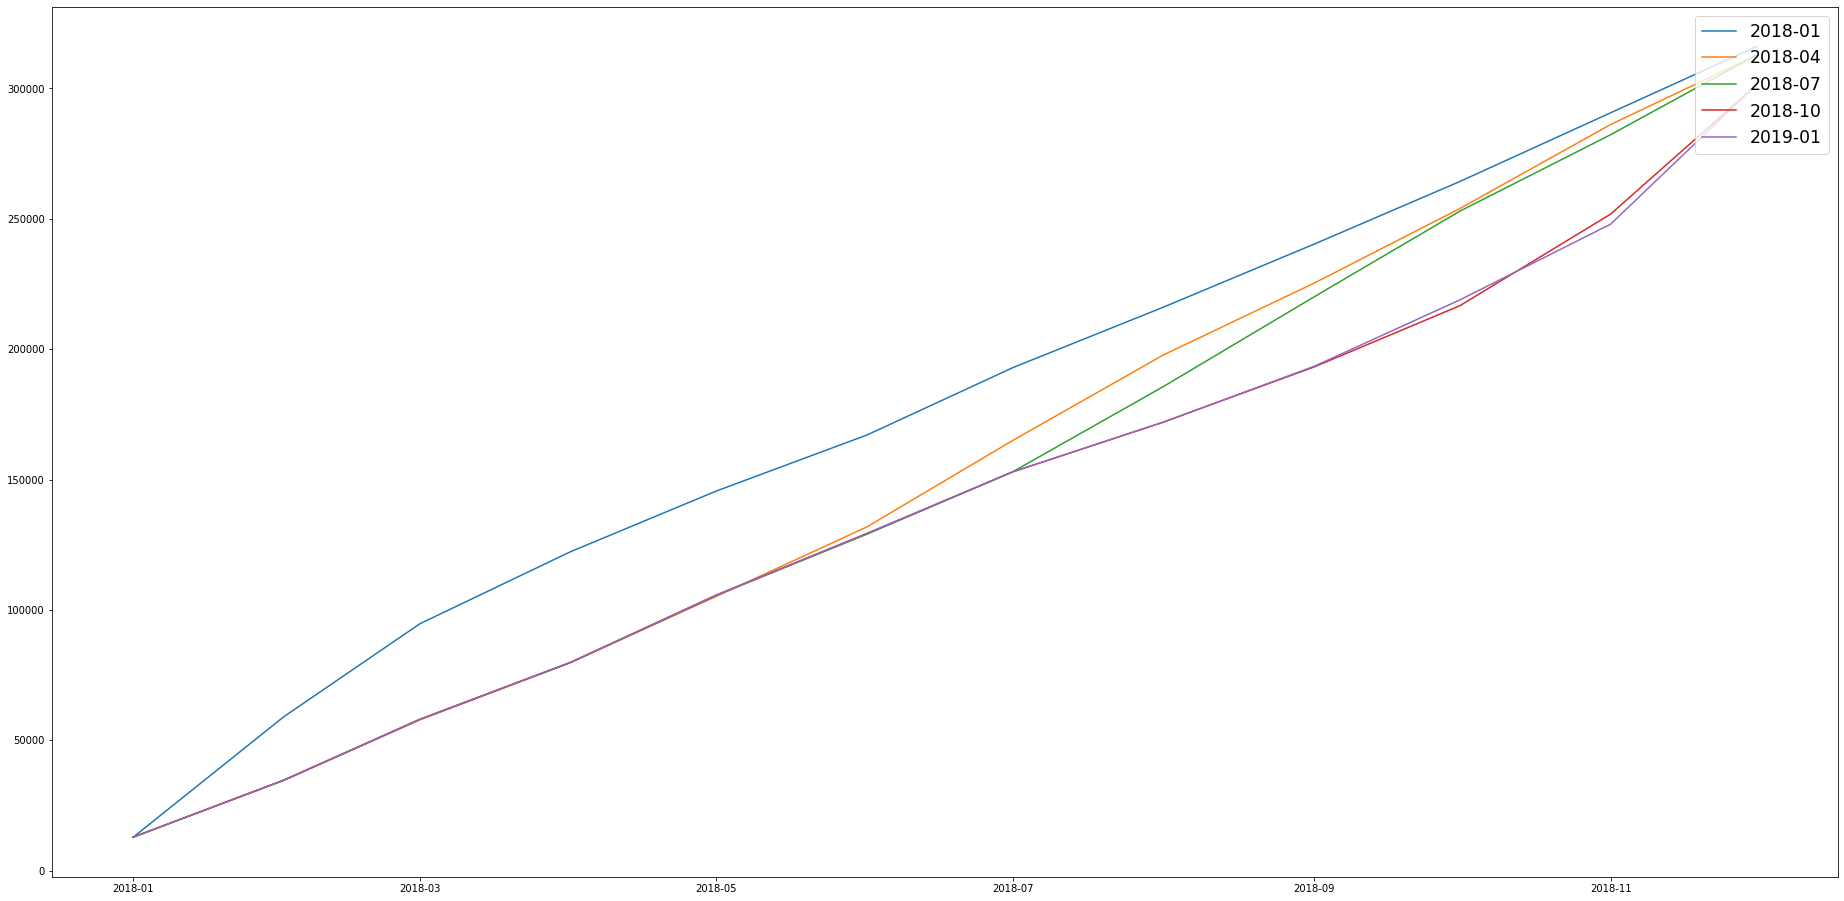

In [62]:
fig = plt.figure(figsize=(32, 16))

forecast_actual_years = ['2018-01',
                         '2018-04',
                         '2018-07',
                         '2018-10',
                         '2019-01']

for report_date in forecast_actual_years:
    df_tmp = df_new[df_new['report_date']==report_date][(df_new['project_date']>=selected_range_start) & (df_new['project_date']<selected_range_end)]

    fund_cum = np.cumsum(df_new[df_new['report_date']==report_date][(df_new['project_date']>=selected_range_start) & (df_new['project_date']<selected_range_end)]['fund'])
    
    fund_cum_dict[report_date] = fund_cum
    
    
    df_tmp['fund_cum'] = pd.Series(fund_cum)
    
    df_tmp = df_tmp.set_index('project_date')

    # Option 1
    # plt.plot(df_tmp['fund'], label=report_date)

    # Option 2
    plt.plot(df_tmp['fund_cum'], label=report_date)

plt.legend(loc='upper right', fontsize='xx-large')


In [39]:
mean_absolute_error(fund_cum_dict[forecast_actual_years[0]], fund_cum_dict[forecast_actual_years[1]]) / fund_cum_dict[forecast_actual_years[1]].mean()

0.13889626942220892

## PoC 3. Forecast Accuracy Evaluation

In [48]:
N_month = 3

In [49]:
df_new['fcst_fund'] = np.nan
df_new['actual_fund'] = np.nan

In [50]:
for i, row in df_new.iterrows():
    if row['report_date'] > row['project_date']:
        df_new.iloc[i,4] = df_new.iloc[i,2]
    else:
        df_new.iloc[i,3] = df_new.iloc[i,2]

In [51]:
df_reporting_date = df_new['report_date'].drop_duplicates().to_frame()
df_reporting_date = df_reporting_date.rename(columns={'report_date':'report_date_last'})
df_reporting_date['report_date'] = df_reporting_date['report_date_last'].shift(-1)
df_reporting_date = df_reporting_date.dropna()
df_reporting_date.tail(3)

,report_date_last,report_date
675,2019-08-01,2019-09-01
687,2019-09-01,2019-10-01
699,2019-10-01,2019-11-01


In [52]:
df_2T_list = []
for index, row in df_reporting_date.iterrows():
    last_month = row['report_date_last'].strftime("%Y-%m")
    current_month = row['report_date'].strftime("%Y-%m")
    df_T_1 = df_new[df_new['report_date']==last_month][['project_date','fund']].set_index('project_date').rolling(N_month, center=False).sum().shift(-(N_month-1)).rename(columns={'fund':'fund_[T-1]'})
    df_T = df_new[df_new['report_date']==current_month][['project_date','fund']].set_index('project_date').rolling(N_month, center=False).sum().shift(-(N_month-1)).rename(columns={'fund':'fund_[T]'})
    df_2T = df_T_1.merge(df_T, left_index=True, right_index=True)[last_month]
    df_2T_list.append(df_2T)

In [53]:
df_2T_ACT_FCST = pd.concat(df_2T_list)

In [54]:
df_2T_ACT_FCST['FCST_ERR'] = abs(df_2T_ACT_FCST['fund_[T-1]'] - df_2T_ACT_FCST['fund_[T]']) * 2 / (df_2T_ACT_FCST['fund_[T-1]'] + df_2T_ACT_FCST['fund_[T]'])

In [55]:
df_2T_ACT_FCST['2019']

,fund_[T-1],fund_[T],FCST_ERR
project_date,,,
2019-01-01,59455.0,52250.0,0.129000
2019-02-01,83213.0,72812.0,0.133325
2019-03-01,83170.0,68960.0,0.186814
2019-04-01,83796.0,67831.0,0.210583
2019-05-01,83989.0,75131.0,0.111337
2019-06-01,84618.0,74269.0,0.130269
2019-07-01,85344.0,79695.0,0.068457
2019-08-01,93355.0,86799.0,0.072782
2019-09-01,104833.0,93302.0,0.116395


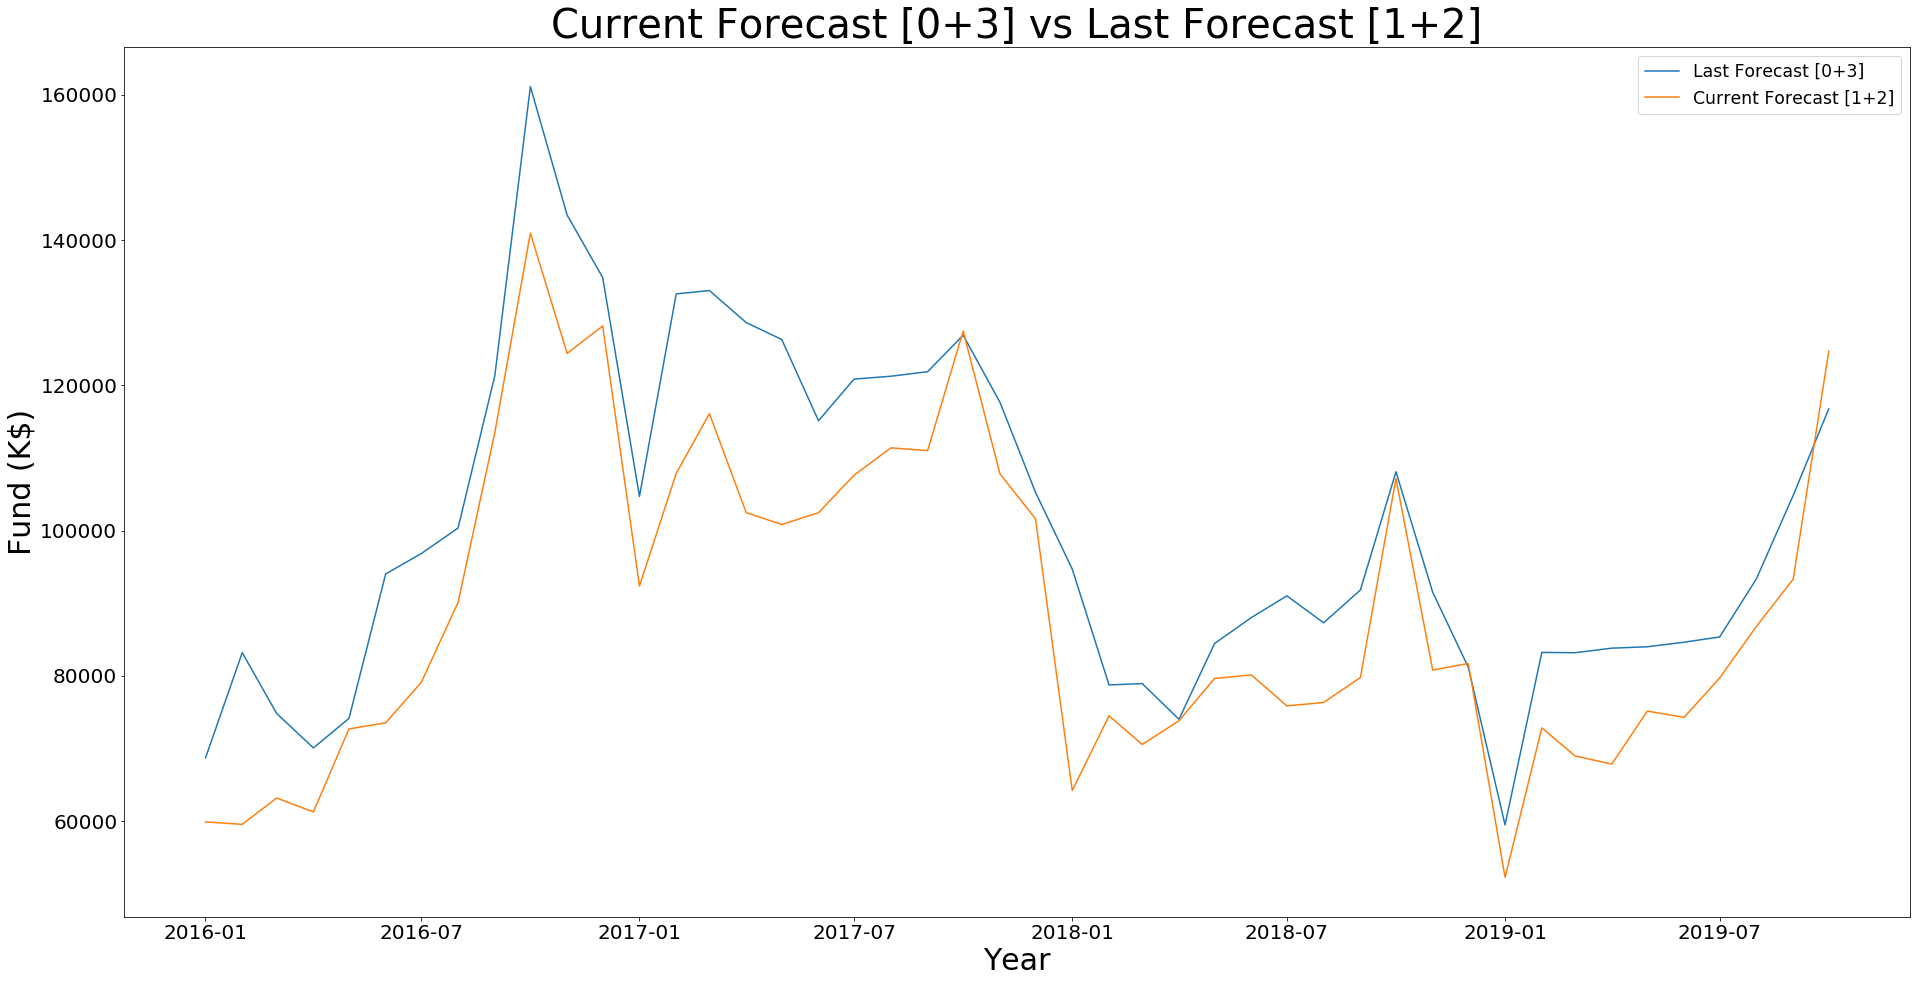

In [56]:
fig = plt.figure(figsize=(32, 16))

plt.plot(df_2T_ACT_FCST['fund_[T-1]'], label=f"Last Forecast [0+{N_month}]")
plt.plot(df_2T_ACT_FCST['fund_[T]'], label=f"Current Forecast [1+{N_month-1}]")

plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('Year', size = 30)
plt.ylabel('Fund (K$)', size = 30)
plt.title(f'Current Forecast [0+{N_month}] vs Last Forecast [1+{N_month-1}]', size = 40)

plt.legend(loc='upper right', fontsize='xx-large')


Text(0.5, 1.0, 'Forecasting Percentage Error: [0+3] vs [1+2]')

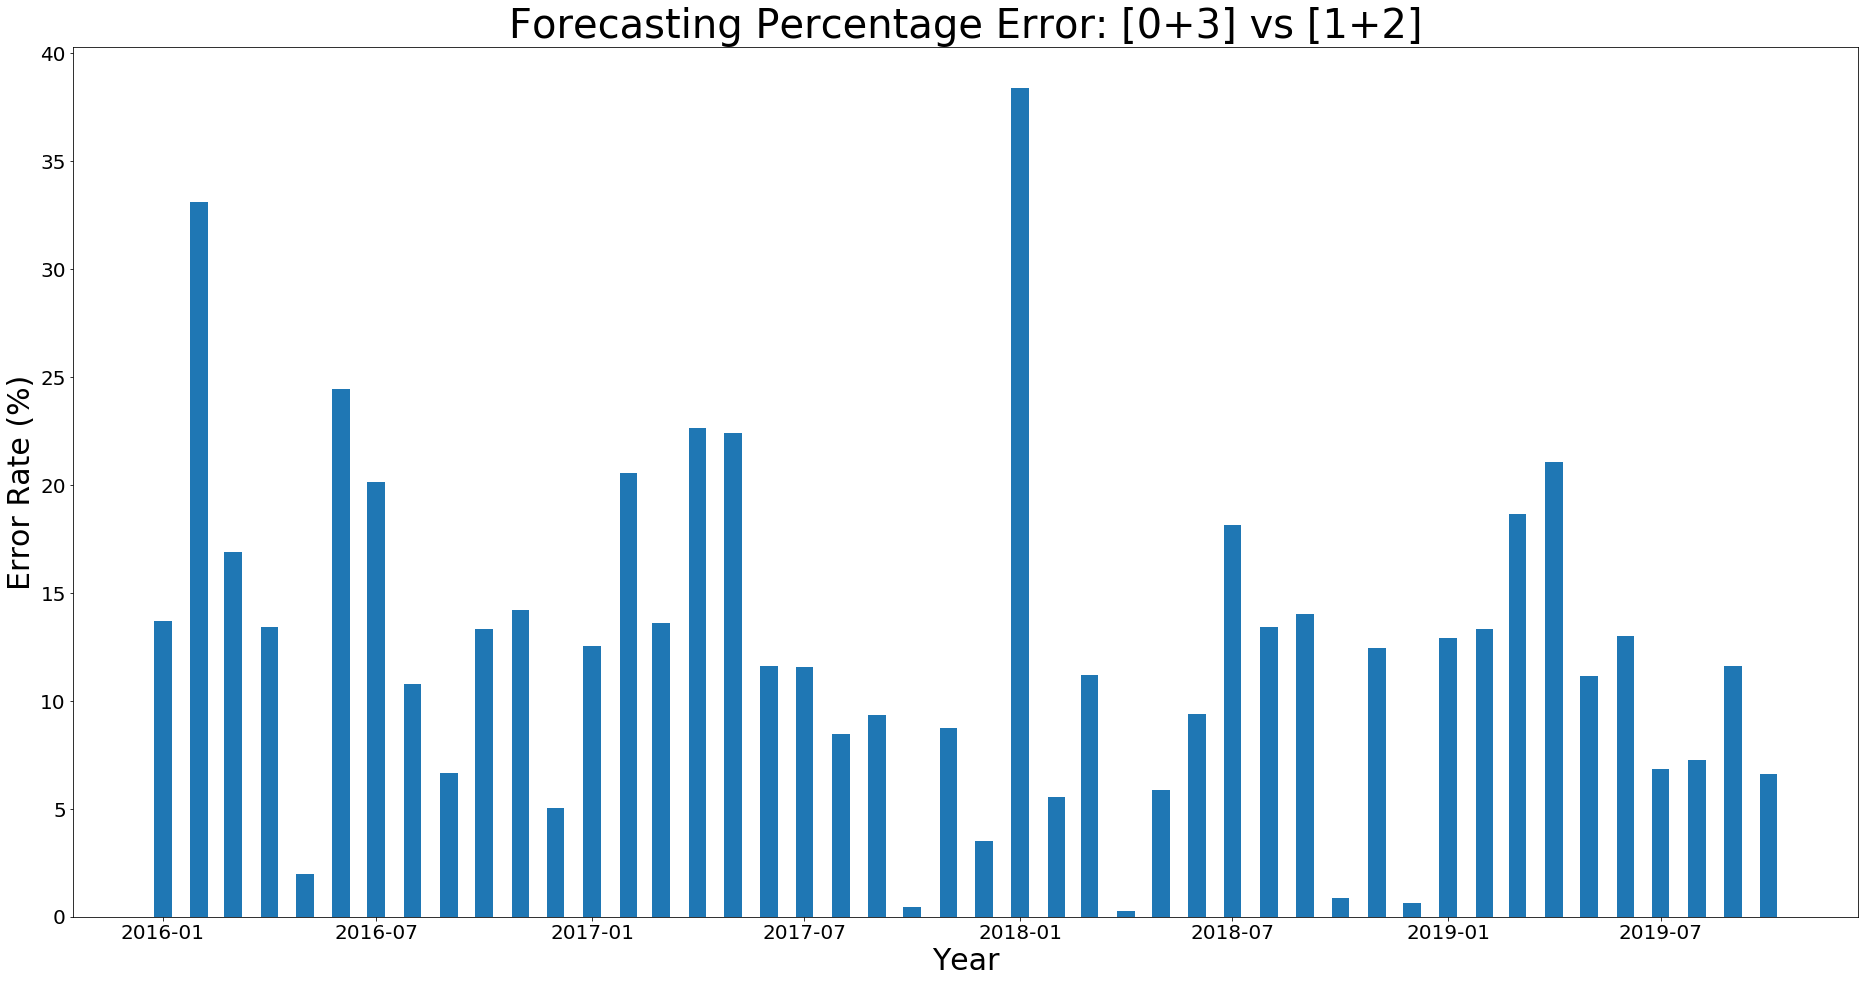

In [57]:
fig, ax = plt.subplots(figsize=(32, 16))
# fig, ax = plt.subplots()
ax.bar(df_2T_ACT_FCST.index, df_2T_ACT_FCST['FCST_ERR']*100, width=15)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('Year', size = 30)
plt.ylabel('Error Rate (%)', size = 30)
plt.title(f'Forecasting Percentage Error: [0+{N_month}] vs [1+{N_month-1}]', size = 40)